# بخش ۱: کتابخانه‌ها و کلاس DataLoader

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

class DataLoader:
    def __init__(self):
        self.scalers = {}
        self.encoders = {}

    def create_time_series_data(self, data, input_window=5, forecast_horizon=3):
        X, y = [], []
        target_offset = forecast_horizon
        max_idx = len(data) - input_window - target_offset + 1
        
        for i in range(max_idx):
            window = data[i : i + input_window]
            target = data[i + input_window + target_offset - 1]
            X.append(window)
            y.append(target)
            
        return np.array(X).reshape(len(X), -1), np.array(y).reshape(len(y), -1)

    def load_dataset(self, name):
        base_path = '../Datasets/Data/dataset/'
        
        if name == 'temperature':
            df = pd.read_excel(base_path + 'regression/Temperature Dataset.xlsx', header=None)
            data = df.values.flatten().reshape(-1, 1)
            scaler = MinMaxScaler()
            data_scaled = scaler.fit_transform(data)
            self.scalers[name] = scaler
            X, y = self.create_time_series_data(data_scaled)
            return train_test_split(X, y, test_size=0.3, shuffle=False), 'regression'

        elif name == 'stock':
            df = pd.read_excel(base_path + 'regression/Tehran Stock Exchange-index of 30 big company.xlsx', header=None)
            data = df.values.flatten().reshape(-1, 1)
            scaler = MinMaxScaler()
            data_scaled = scaler.fit_transform(data)
            self.scalers[name] = scaler
            X, y = self.create_time_series_data(data_scaled)
            return train_test_split(X, y, test_size=0.3, shuffle=False), 'regression'

        elif name == 'iris':
            df = pd.read_excel(base_path + 'classification/classification-iris.xlsx', header=None)
            X_raw = df.iloc[:, :-1].values
            y_raw = df.iloc[:, -1].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X_raw)
            encoder = OneHotEncoder(sparse_output=False)
            y = encoder.fit_transform(y_raw)
            self.encoders[name] = encoder
            return train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42), 'classification'

        elif name == 'cancer':
            df = pd.read_csv(base_path + 'classification/classification_breast-cancer-wisconsin.csv', header=None)
            df = df.replace('?', np.nan).dropna().astype(float)
            X_raw = df.iloc[:, 1:-1].values
            y_raw = df.iloc[:, -1].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X_raw)
            encoder = OneHotEncoder(sparse_output=False)
            y = encoder.fit_transform(y_raw)
            self.encoders[name] = encoder
            return train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42), 'classification'

        elif name == 'parkinsons':
            df = pd.read_csv(base_path + 'classification/classification-parkinsons.csv')
            if 'name' in df.columns: df = df.drop(columns=['name'])
            target_col = 'status'
            X_raw = df.drop(columns=[target_col]).values
            y_raw = df[target_col].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X_raw)
            encoder = OneHotEncoder(sparse_output=False)
            y = encoder.fit_transform(y_raw)
            self.encoders[name] = encoder
            return train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42), 'classification'

# بخش ۲: پیاده‌سازی کلاس پایه و موتور بهینه‌سازی گوس-نیوتن

In [ ]:
class BaseNeuralNetwork:
    def __init__(self, layers, task_type, learning_rate=0.1, epochs=20):
        self.layers = layers
        self.task_type = task_type
        self.lr = learning_rate
        self.epochs = epochs
        self.params = {}
        self.history = {'train_loss': [], 'test_loss': []}
        
        np.random.seed(42)
        for i in range(1, len(layers)):
            limit = np.sqrt(6 / (layers[i-1] + layers[i]))
            self.params[f'W{i}'] = np.random.uniform(-limit, limit, (layers[i-1], layers[i]))
            self.params[f'b{i}'] = np.zeros((1, layers[i]))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def flex_sigmoid(self, z, a):
        val = np.abs(a) * z
        return (2 * np.abs(a)) / (1 + np.exp(-np.clip(val, -500, 500)))

    def full_flex_activation(self, net, alpha, beta):
        epsilon = 1e-6
        ratio = alpha / (beta + epsilon)
        z = ratio * net
        exp_z = np.exp(np.clip(z, -500, 500))
        return ratio + (1 - exp_z) / (1 + exp_z)
    
    def _activation_derivative(self, Z, A, i, params):
        if i == len(self.layers) - 1 and self.task_type == 'regression':
            return np.ones_like(Z)
        
        if f'a{i}' in params:  
            a = params[f'a{i}']
            val = np.abs(a) * Z
            sig = 1 / (1 + np.exp(-np.clip(val, -500, 500)))
            return np.abs(a) * 2 * np.abs(a) * sig * (1 - sig)
            
        elif f'alpha{i}' in params: 
            alpha = params[f'alpha{i}']
            beta = params[f'beta{i}'] + 1e-6
            k = alpha / beta
            exp_z = np.exp(np.clip(k * Z, -500, 500))
            df_dz = k * (-2 * exp_z) / ((1 + exp_z)**2)
            return df_dz
            
        else: 
            return A * (1 - A)

    def _param_derivative(self, Z, A, i, params, param_name):
        if param_name == f'a{i}':
            a = params[f'a{i}']
            val = np.abs(a) * Z
            sig = 1 / (1 + np.exp(-np.clip(val, -500, 500)))

            return 2 * np.sign(a) * sig + 2 * np.abs(a) * sig * (1 - sig) * Z * np.sign(a)
        
        elif param_name == f'alpha{i}' or param_name == f'beta{i}':
            alpha = params[f'alpha{i}']
            beta = params[f'beta{i}'] + 1e-6
            
            k = alpha / beta
            u = k * Z
            exp_u = np.exp(np.clip(u, -500, 500))
            
            df_dk = 1.0 + (-2 * exp_u * Z) / ((1 + exp_u)**2)
            
            if param_name == f'alpha{i}':
                return df_dk * (1.0 / beta)
            else:
                return df_dk * (-alpha / (beta**2))
            
        return np.zeros_like(Z)

    def forward_with_cache(self, X, params):
        cache = {'A0': X}
        A = X
        L = len(self.layers) - 1
        
        for i in range(1, L + 1):
            W = params[f'W{i}']
            b = params[f'b{i}']
            Z = np.dot(A, W) + b
            cache[f'Z{i}'] = Z
            
            if i == L: 
                if self.task_type == 'classification':
                    A = self.softmax(Z)
                else:
                    A = Z
            else: 
                if f'alpha{i}' in params: 
                    A = self.full_flex_activation(Z, params[f'alpha{i}'], params[f'beta{i}'])
                elif f'a{i}' in params: 
                    A = self.flex_sigmoid(Z, params[f'a{i}'])
                else: 
                    A = self.sigmoid(Z)
            
            cache[f'A{i}'] = A
            
        return A, cache

    def forward(self, X):
        A, _ = self.forward_with_cache(X, self.params)
        return A

    def compute_loss(self, y_true, y_pred):
        if self.task_type == 'regression':
            return np.mean(0.5 * (y_true - y_pred)**2)
        else:
            m = y_true.shape[0]
            log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-9)
            return np.sum(log_likelihood) / m

    def flatten_params(self):
        flat = []
        keys = sorted(self.params.keys())
        for key in keys:
            flat.append(self.params[key].flatten())
        return np.concatenate(flat), keys

    def unflatten_params(self, flat_params, keys):
        reconstructed = {}
        idx = 0
        for key in keys:
            shape = self.params[key].shape
            size = np.prod(shape)
            reconstructed[key] = flat_params[idx:idx+size].reshape(shape)
            idx += size
        return reconstructed

    
    def compute_jacobian(self, X, y_target, current_params_flat, keys):
        params = self.unflatten_params(current_params_flat, keys)
        
        y_pred, cache = self.forward_with_cache(X, params)
        
        n_samples = X.shape[0]
        n_outputs = y_pred.shape[1]
        n_params = len(current_params_flat)
        
        residuals = (y_target - y_pred)
        residuals_flat = residuals.flatten()
        
        J = np.zeros((n_samples * n_outputs, n_params))
        
        L = len(self.layers) - 1
        
        for i in range(n_samples):
            for k in range(n_outputs):
                row_idx = i * n_outputs + k
                
                dZ = np.zeros((1, n_outputs))
                dZ[0, k] = 1.0 
                
                grads = {}
                
                for l in range(L, 0, -1):
                    A_prev = cache[f'A{l-1}'] 
                    A_prev_sample = A_prev[i:i+1]
                    Z_curr = cache[f'Z{l}']
                    Z_curr_sample = Z_curr[i:i+1]
                    A_curr_sample = cache[f'A{l}'][i:i+1]

                    grads[f'W{l}'] = np.dot(A_prev_sample.T, dZ)
                    grads[f'b{l}'] = dZ
                    
                    if f'a{l}' in params:
                        da = self._param_derivative(Z_curr_sample, A_curr_sample, l, params, f'a{l}')
                        grads[f'a{l}'] = dZ * da
                    
                    if f'alpha{l}' in params:
                        da = self._param_derivative(Z_curr_sample, A_curr_sample, l, params, f'alpha{l}')
                        db = self._param_derivative(Z_curr_sample, A_curr_sample, l, params, f'beta{l}')
                        grads[f'alpha{l}'] = dZ * da
                        grads[f'beta{l}'] = dZ * db
                    
                    if l > 1:
                        W_curr = params[f'W{l}']
                        dA_prev = np.dot(dZ, W_curr.T)
                        
                        Z_prev = cache[f'Z{l-1}'][i:i+1]
                        A_prev_val = cache[f'A{l-1}'][i:i+1]
                        
                        d_act = self._activation_derivative(Z_prev, A_prev_val, l-1, params)
                        dZ = dA_prev * d_act
                
                col_idx = 0
                for key in keys:
                    g = grads.get(key, np.zeros_like(params[key]))
                    J[row_idx, col_idx : col_idx + g.size] = g.flatten()
                    col_idx += g.size
                    
        return J, residuals_flat
    
    def _solve_gauss_newton(self, J, vector, flat_params, update_sign=1.0):
        H = np.dot(J.T, J)
        g = np.dot(J.T, vector)
        
        mu = 1e-3
        H_damped = H + mu * np.eye(H.shape[0])
        
        try:
            delta = np.linalg.solve(H_damped, g)
        except np.linalg.LinAlgError:
            delta = np.dot(np.linalg.pinv(H_damped), g)
            
        new_flat_params = flat_params + (update_sign * self.lr * delta)
        return new_flat_params

    def gauss_newton_step(self, X, y):
        flat_params, keys = self.flatten_params()
        J, residuals = self.compute_jacobian(X, y, flat_params, keys)
        
        new_params = self._solve_gauss_newton(J, residuals, flat_params, update_sign=1.0)
        
        self.params = self.unflatten_params(new_params, keys)

    def train(self, X_train, y_train, X_test, y_test):
        for epoch in range(self.epochs):
            self.gauss_newton_step(X_train, y_train)
            
            tr_loss = self.compute_loss(y_train, self.forward(X_train))
            te_loss = self.compute_loss(y_test, self.forward(X_test))
            
            self.history['train_loss'].append(tr_loss)
            self.history['test_loss'].append(te_loss)

def plot_final_results(model, X_test, y_test, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(model.history['train_loss'], label='Train Loss')
    plt.plot(model.history['test_loss'], label='Test Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    y_pred = model.forward(X_test)
    
    if model.task_type == 'regression':
        limit = min(100, len(y_test))
        plt.plot(y_test[:limit], 'o', label='Actual', alpha=0.6)
        plt.plot(y_pred[:limit], '-', label='Predicted', linewidth=2)
        plt.title(f'{title} - Regression')
        plt.savefig(f"{title}_regression.png")
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE: {mse:.5f}")
    else:
        y_true_cls = np.argmax(y_test, axis=1)
        y_pred_cls = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(y_true_cls, y_pred_cls)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{title} - Confusion Matrix')
        plt.savefig(f"{title}_confusion_matrix.png")
        acc = accuracy_score(y_true_cls, y_pred_cls)
        print(f"Accuracy: {acc:.2%}")
        
    plt.tight_layout()
    plt.show()

# بخش ۳: شبکه استاندارد (Standard MLP)

MSE: 0.00596


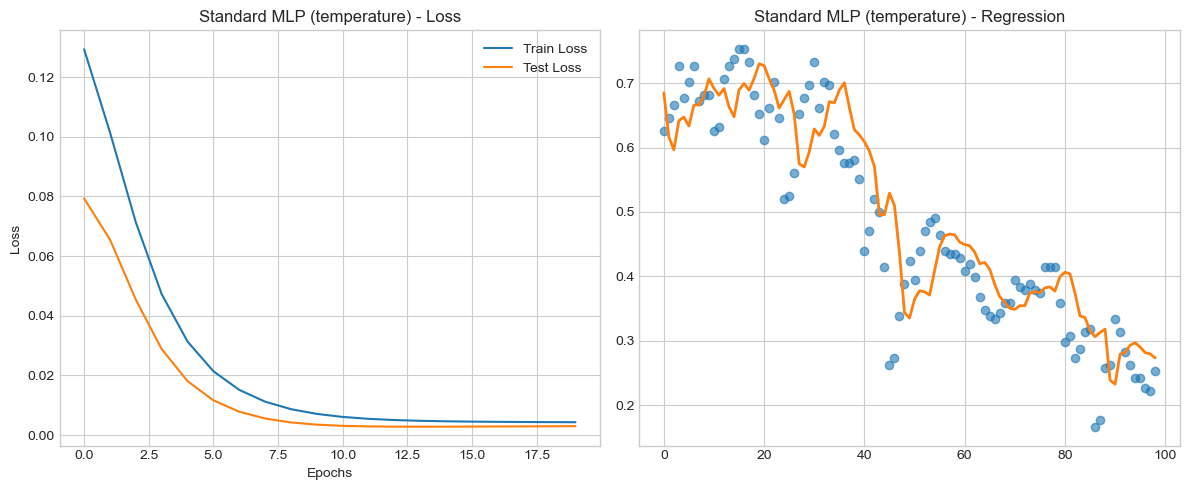

MSE: 0.00081


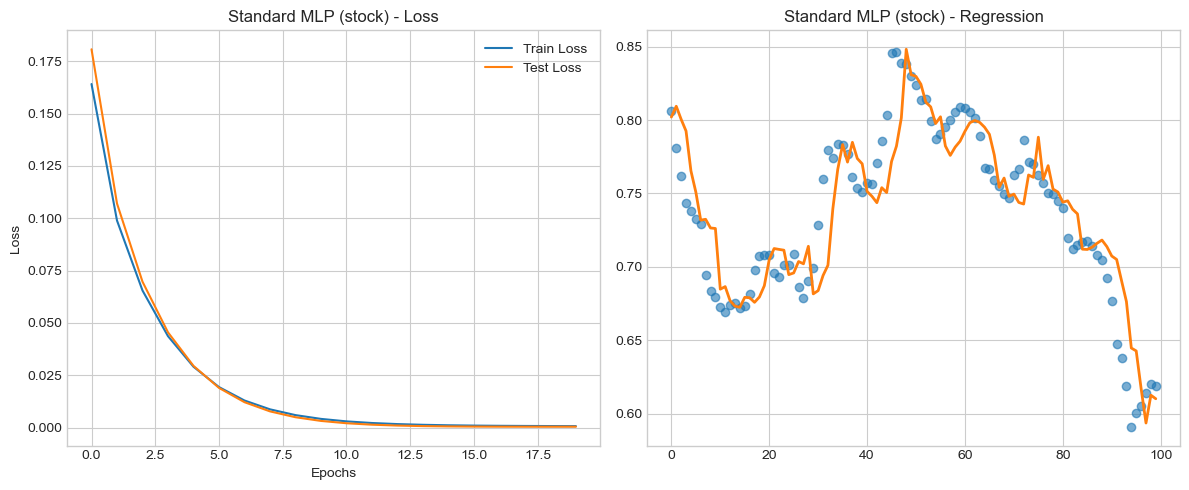

Accuracy: 93.33%


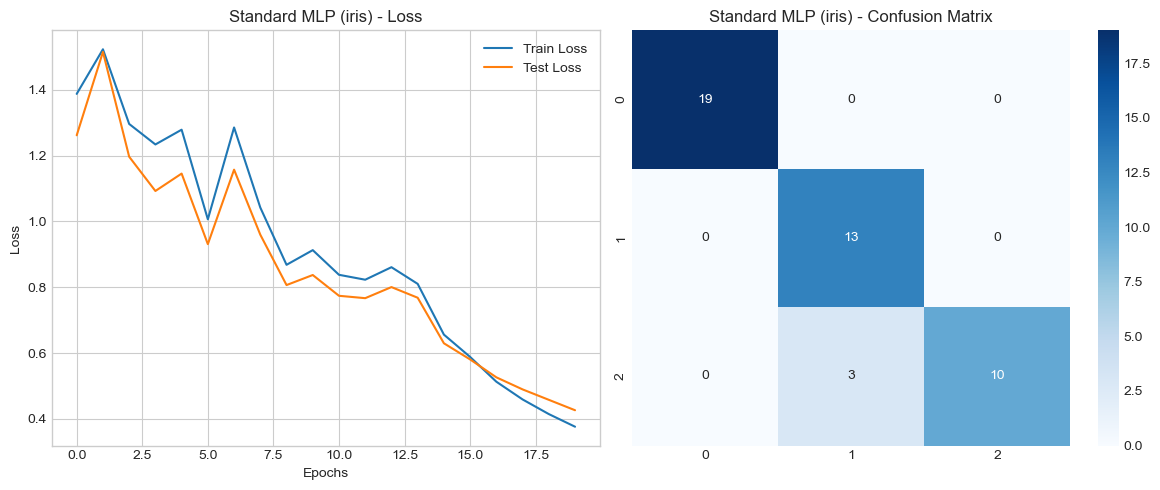

Accuracy: 97.07%


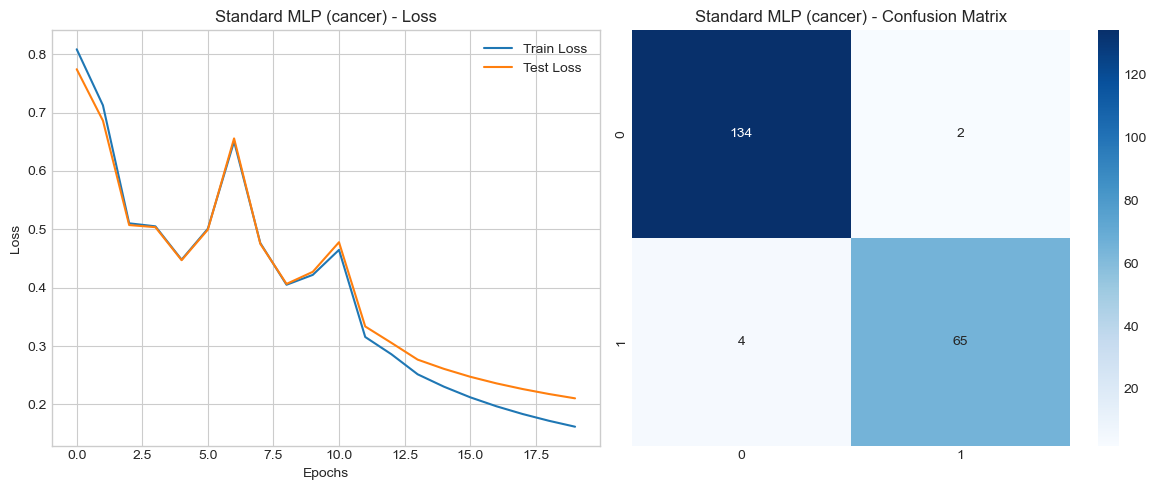

Accuracy: 89.83%


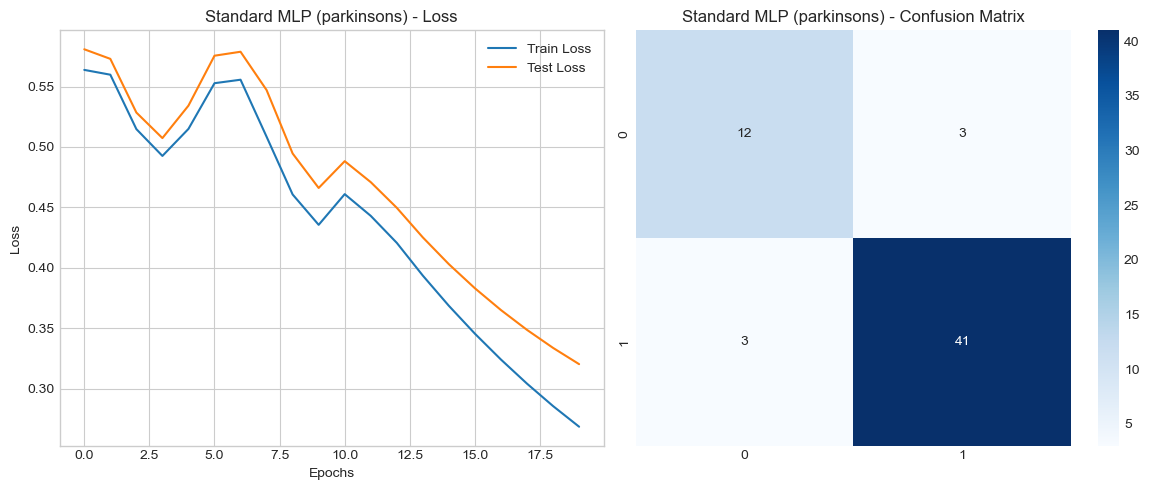

In [3]:
def run_standard_mlp(dataset_name, learning_rate=0.2, epochs=20):
    loader = DataLoader()
    data = loader.load_dataset(dataset_name)
    X_train, X_test, y_train, y_test = data[0]
    task_type = data[1]
    
    layers = [X_train.shape[1], 10, 10, 10, y_train.shape[1]]
    model = BaseNeuralNetwork(layers, task_type, learning_rate=learning_rate, epochs=epochs)
    model.train(X_train, y_train, X_test, y_test)
    plot_final_results(model, X_test, y_test, f'Standard MLP ({dataset_name})')

run_standard_mlp('temperature')
run_standard_mlp('stock')
run_standard_mlp('iris')
run_standard_mlp('cancer')
run_standard_mlp('parkinsons', learning_rate=0.15)

# بخش ۴: شبکه عاطفی (Emotional NN)

MSE: 0.00880


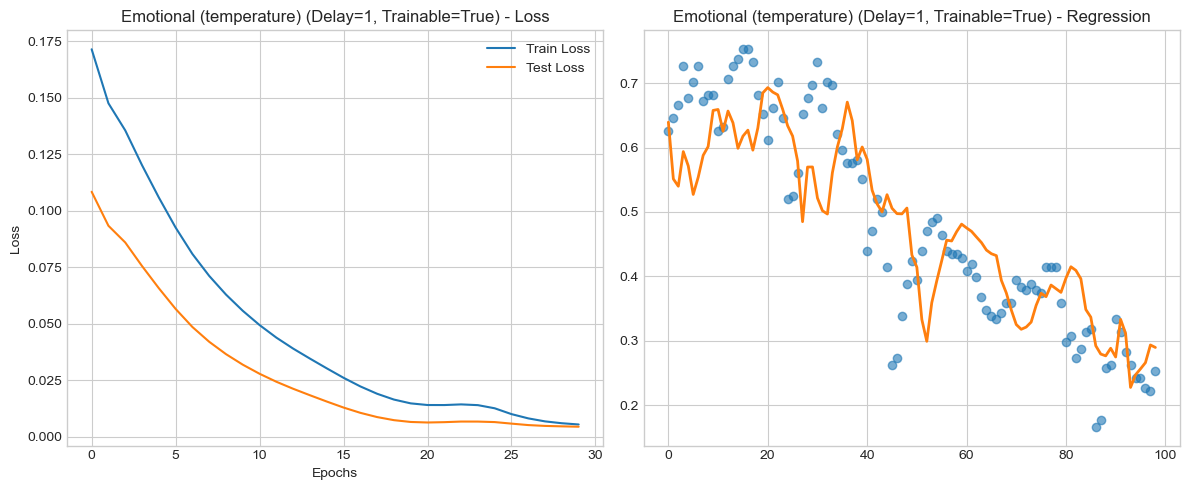

Learned k1: 0.2460, k2: 0.7540
MSE: 0.00123


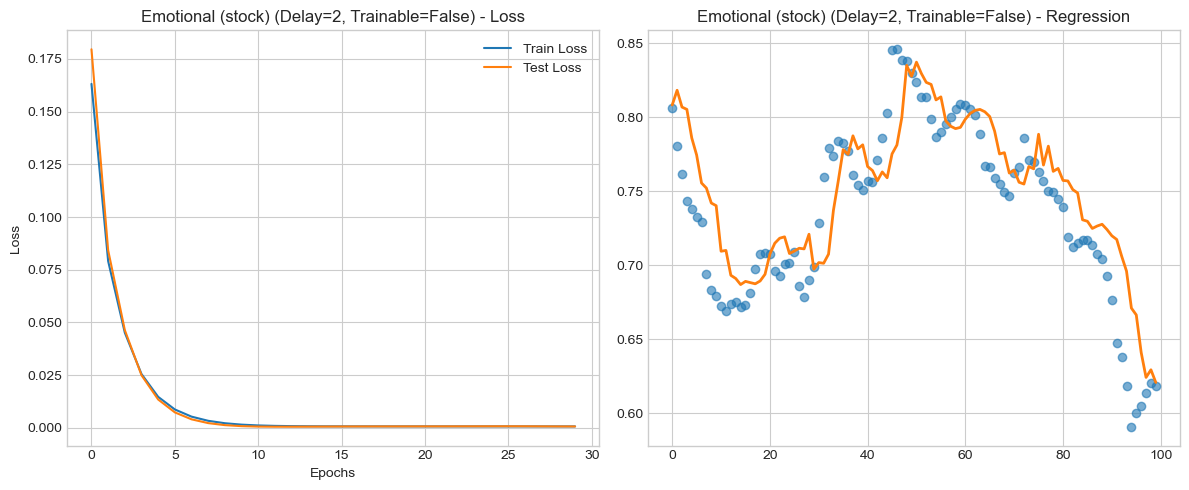

Accuracy: 97.78%


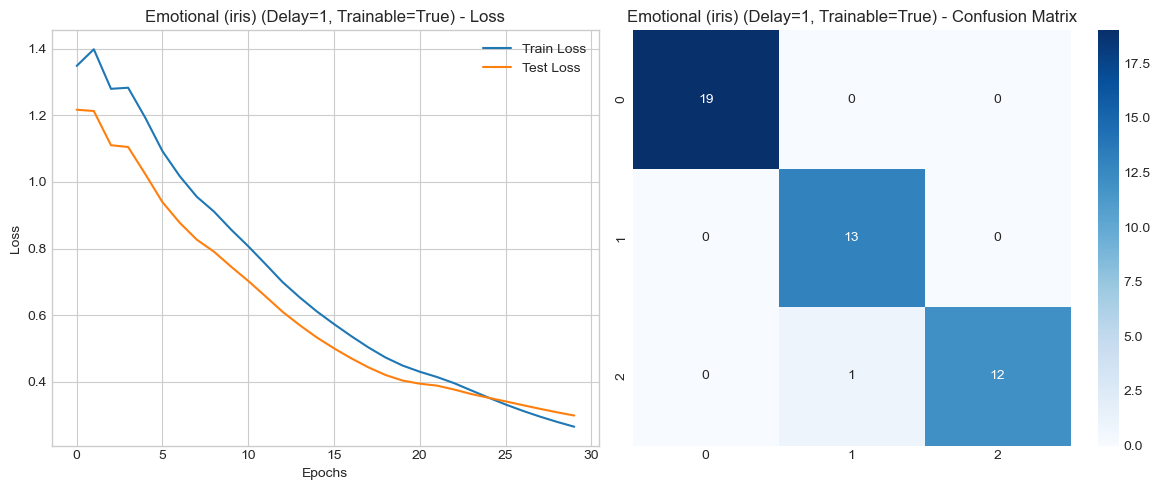

Learned k1: 0.9987, k2: 0.0013
Accuracy: 94.63%


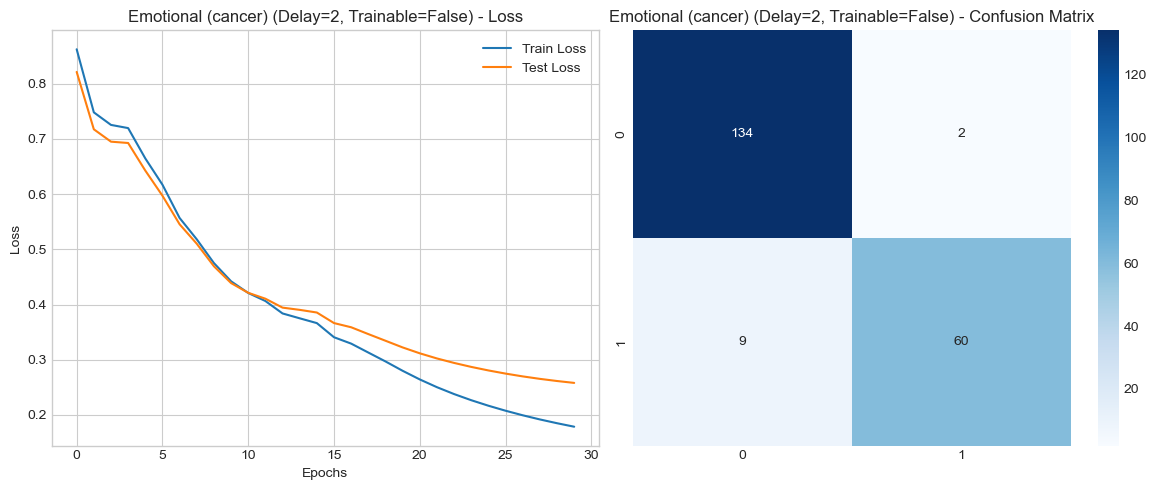

Accuracy: 88.14%


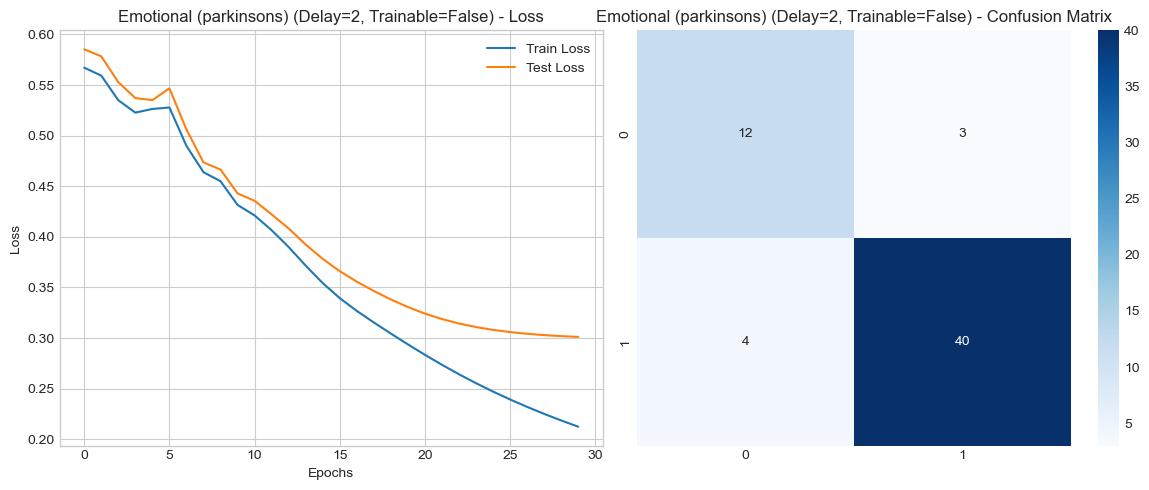

In [4]:
class EmotionalNN(BaseNeuralNetwork):
    def __init__(self, layers, task_type, delay=1, trainable_k=False, flexible=False, **kwargs):
        super().__init__(layers, task_type, **kwargs)
        self.delay = delay
        self.trainable_k = trainable_k
        
        if trainable_k:
            self.params['emo_alpha'] = np.array([0.0, 0.0]) 
        
        if flexible:
            for i in range(1, len(layers) - 1):
                self.params[f'a{i}'] = np.ones((1, layers[i]))

    def get_k(self):
        if self.trainable_k:
            vals = self.params['emo_alpha']
            exp_vals = np.exp(vals - np.max(vals))
            return exp_vals / np.sum(exp_vals)
        return np.array([0.7, 0.3])
    
    def _compute_softmax_grads(self, alpha_vals):
        ex = np.exp(alpha_vals - np.max(alpha_vals))
        s = np.sum(ex)
        k = ex / s
        
        dk1_da1 = k[0] * (1 - k[0])
        dk1_da2 = -k[0] * k[1]
        
        dk2_da1 = -k[1] * k[0]
        dk2_da2 = k[1] * (1 - k[1])
        
        return np.array([[dk1_da1, dk1_da2], 
                         [dk2_da1, dk2_da2]])

    def compute_emotional_jacobian(self, X, y_target, current_params_flat, keys):
        J_standard, residuals_flat = super().compute_jacobian(X, y_target, current_params_flat, keys)
        
        params = self.unflatten_params(current_params_flat, keys)

        residuals = residuals_flat.reshape(y_target.shape)
        e_curr = residuals 
        
        e_prev = np.roll(e_curr, self.delay, axis=0)
        e_prev[:self.delay] = 0
        
        k = self.get_k()
        k1, k2 = k[0], k[1]
        
        r_vec = (k1 * e_curr + k2 * (e_curr - e_prev)).flatten()
        
        J_emotional = -(k1 + k2) * J_standard
        
        if self.trainable_k:
            J_softmax = self._compute_softmax_grads(self.params['emo_alpha'])

            # dr/dk1
            term_e = e_curr.flatten()
            # dr/dk2
            term_de = (e_curr - e_prev).flatten()

            col_idx = 0
            alpha_col_idx = -1
            for key in keys:
                if key == 'emo_alpha':
                    alpha_col_idx = col_idx
                    break
                col_idx += params[key].size
            
            if alpha_col_idx != -1:
                dr_da1 = term_e * J_softmax[0, 0] + term_de * J_softmax[1, 0]
                dr_da2 = term_e * J_softmax[0, 1] + term_de * J_softmax[1, 1]
                
                J_emotional[:, alpha_col_idx] = dr_da1
                J_emotional[:, alpha_col_idx+1] = dr_da2

        return J_emotional, r_vec

    def gauss_newton_step(self, X, y):
        flat_params, keys = self.flatten_params()
        J_emo, r_vec = self.compute_emotional_jacobian(X, y, flat_params, keys)
        new_params = self._solve_gauss_newton(J_emo, r_vec, flat_params, update_sign=-1.0)
        self.params = self.unflatten_params(new_params, keys)


def run_emotional_nn(dataset_name, delay=1, trainable=False, flexible=False, learning_rate=0.01, epochs=30):
    loader = DataLoader()
    data = loader.load_dataset(dataset_name)
    X_train, X_test, y_train, y_test = data[0]
    task_type = data[1]
    
    layers = [X_train.shape[1], 10, 10, 10, y_train.shape[1]]
    model = EmotionalNN(layers, task_type, delay=delay, trainable_k=trainable, flexible=flexible, learning_rate=learning_rate, epochs=epochs)
    model.train(X_train, y_train, X_test, y_test)
    if flexible:
        title = f'Flexible and Emotional ({dataset_name}) (Delay={delay}, Trainable={trainable})'
    else:
        title = f'Emotional ({dataset_name}) (Delay={delay}, Trainable={trainable})'
    plot_final_results(model, X_test, y_test, title)
    
    if trainable:
        k = model.get_k()
        print(f"Learned k1: {k[0]:.4f}, k2: {k[1]:.4f}")

run_emotional_nn('temperature', delay=1, trainable=True, learning_rate=0.43)
run_emotional_nn('stock', delay=2, learning_rate=0.4)
run_emotional_nn('iris', trainable=True, learning_rate=0.15)
run_emotional_nn('cancer',delay=2, learning_rate=0.1)
run_emotional_nn('parkinsons', delay=2, learning_rate=0.08)

# بخش 5: شبکه عاطفی انعطاف‌پذیر

MSE: 0.02283


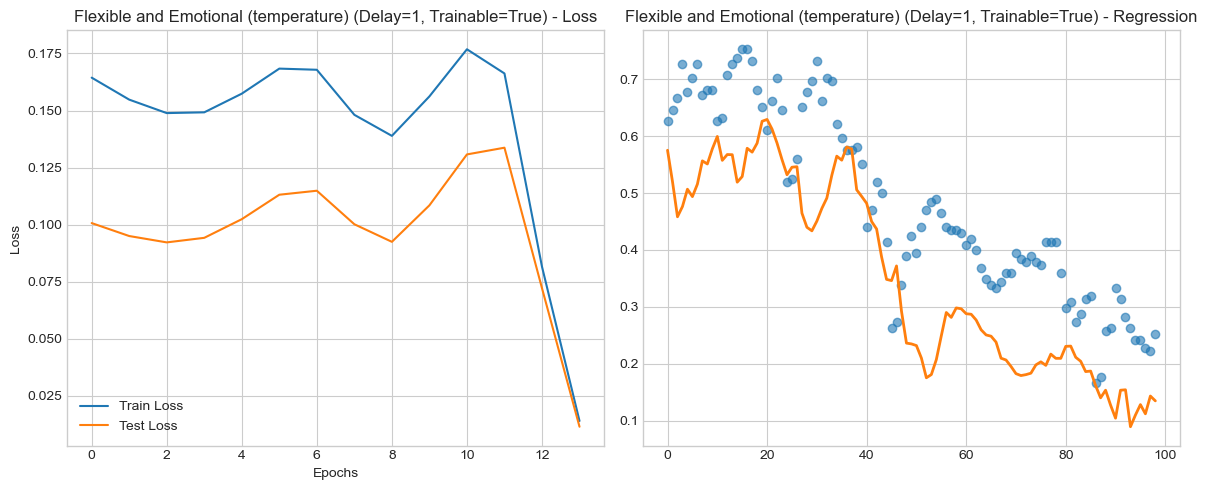

Learned k1: 0.2069, k2: 0.7931
MSE: 0.00180


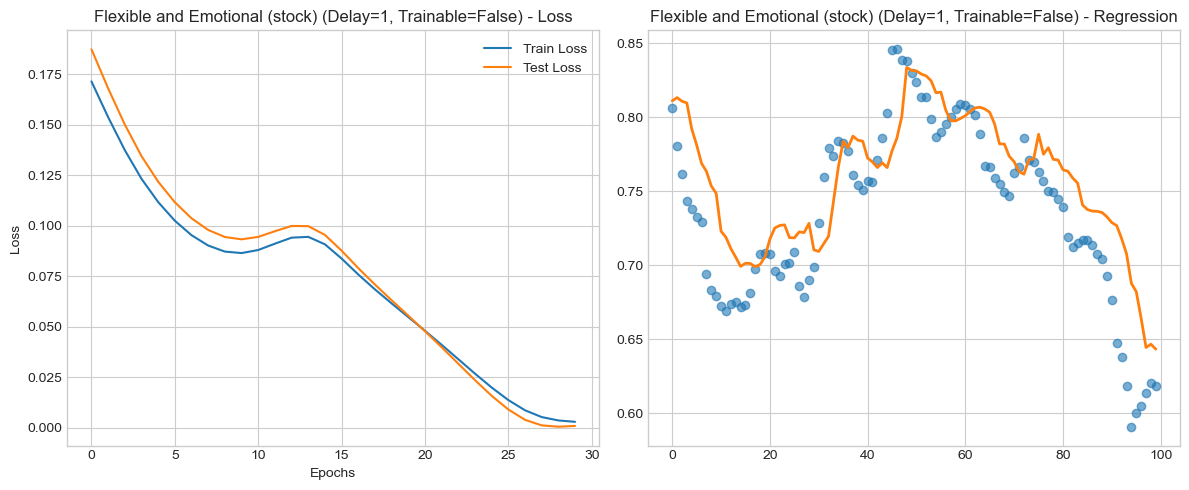

Accuracy: 84.44%


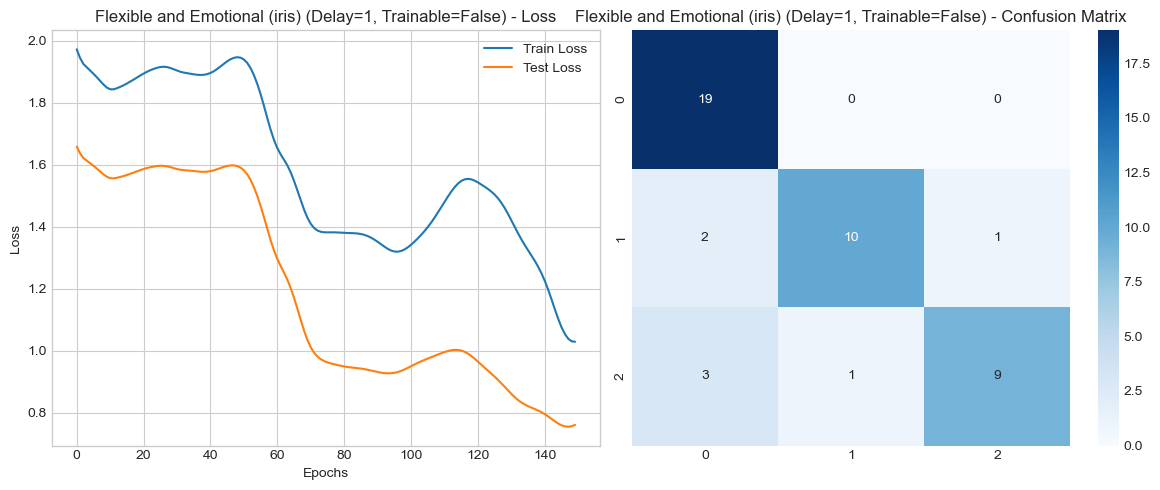

Accuracy: 95.61%


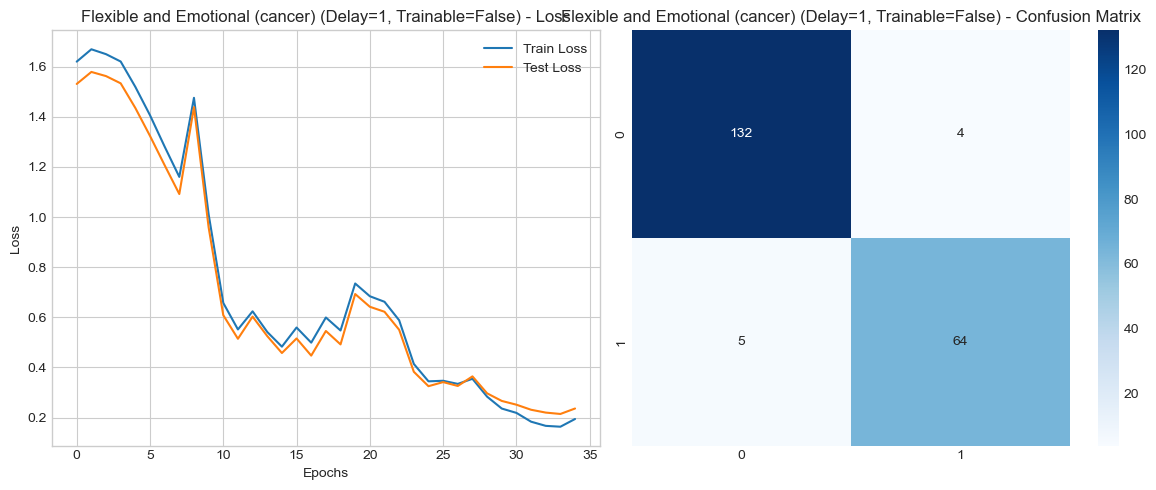

Accuracy: 86.44%


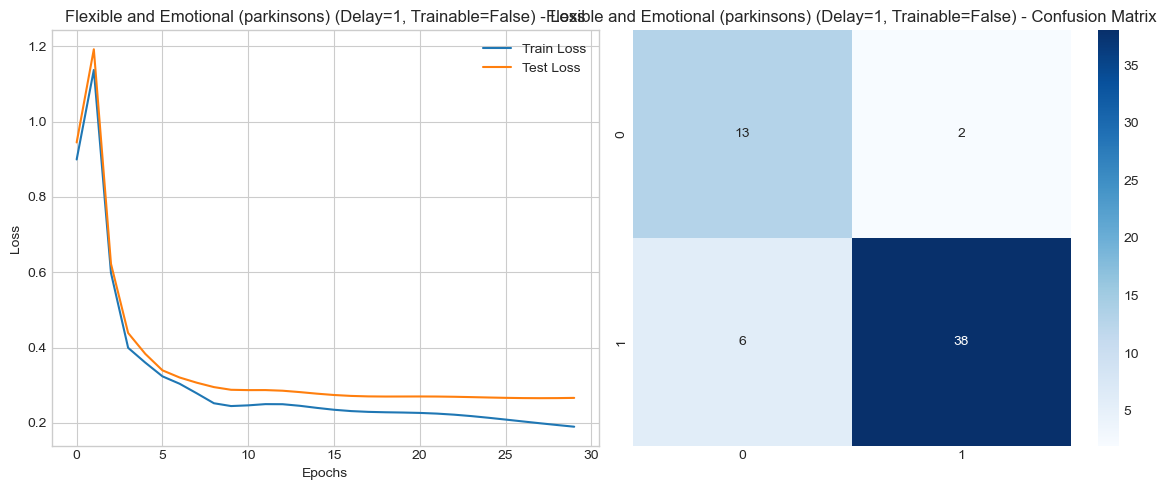

In [5]:
run_emotional_nn('temperature', trainable=True, flexible=True, learning_rate=0.25, epochs=14)
run_emotional_nn('stock', flexible=True, learning_rate=0.09)
run_emotional_nn('iris', flexible=True, learning_rate=0.0075, epochs=150)
run_emotional_nn('cancer', flexible=True, learning_rate=0.05, epochs=35)
run_emotional_nn('parkinsons', flexible=True, learning_rate=0.08)

# بخش 6: سیگموید انعطاف‌پذیر (Flexible Sigmoid)

MSE: 0.00753


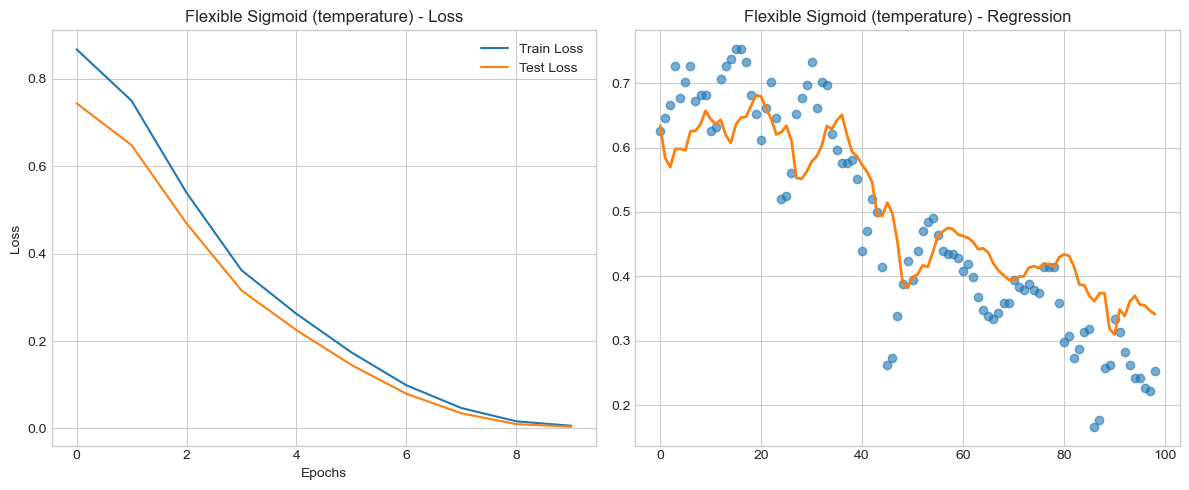

MSE: 0.00203


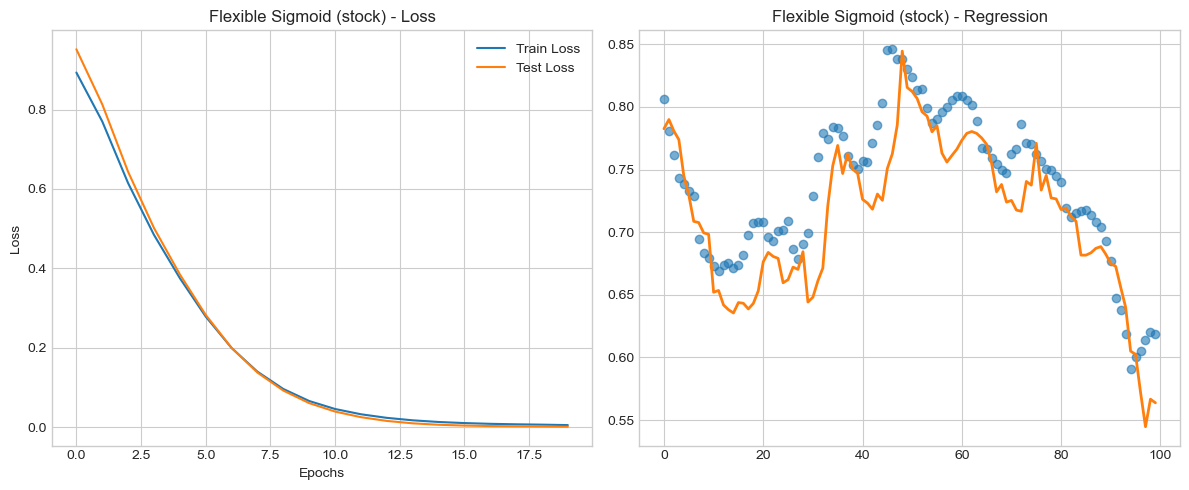

Accuracy: 84.44%


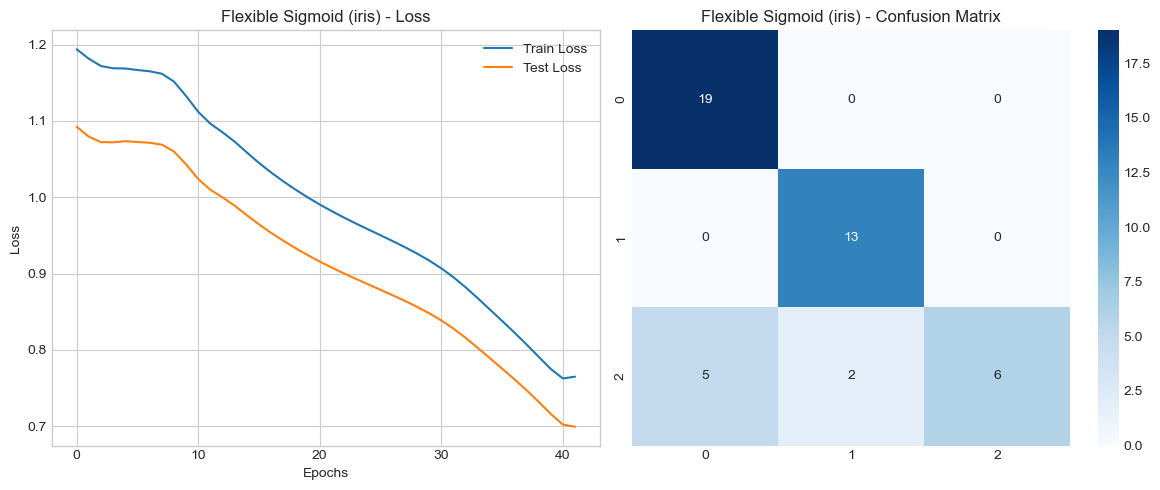

Accuracy: 85.37%


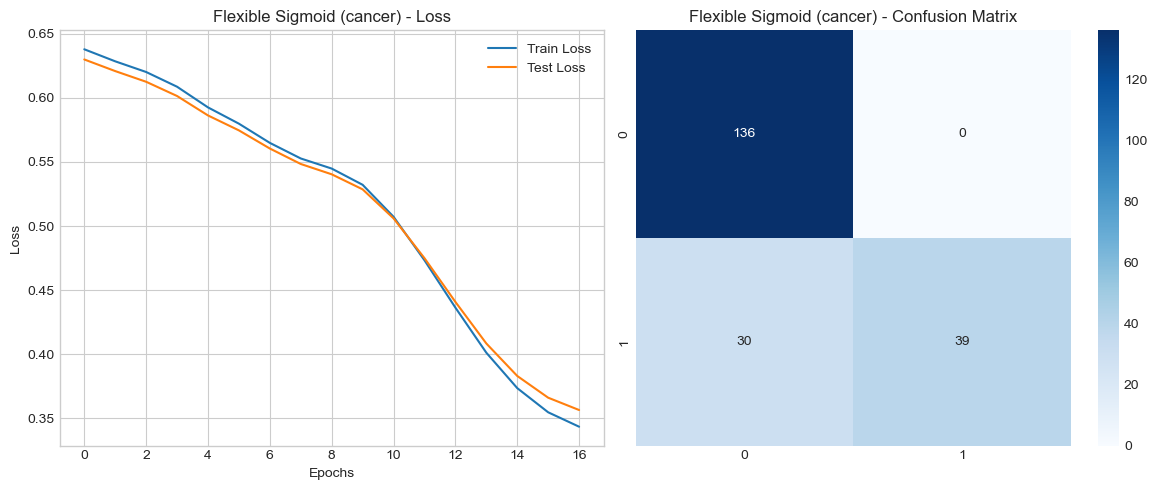

Accuracy: 84.75%


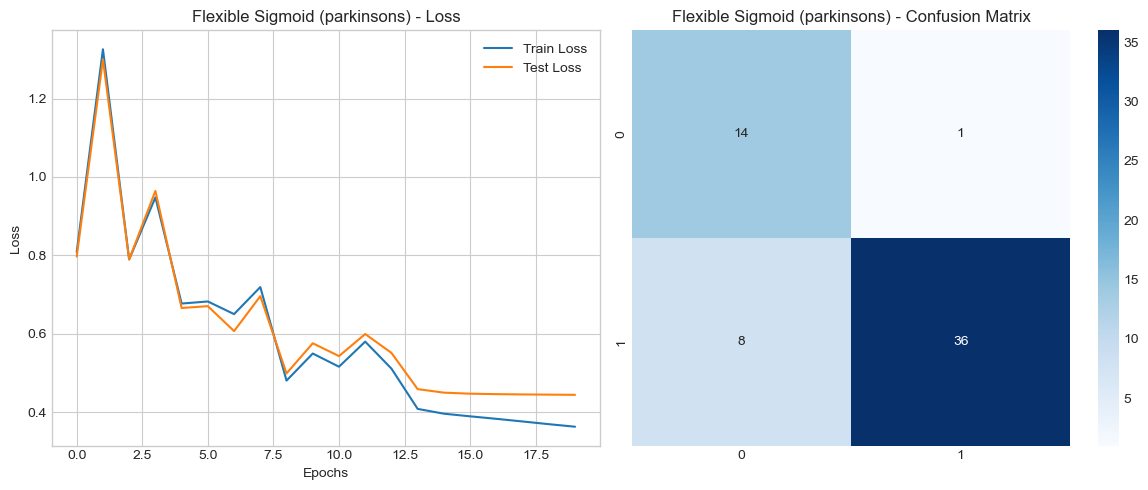

In [6]:
class FlexibleSigmoidNN(BaseNeuralNetwork):
    def __init__(self, layers, task_type, **kwargs):
        super().__init__(layers, task_type, **kwargs)
        
        for i in range(1, len(layers) - 1):
            self.params[f'a{i}'] = np.ones((1, layers[i]))

def run_flexible_sigmoid(dataset_name, learning_rate=0.2, epochs=20):
    loader = DataLoader()
    data = loader.load_dataset(dataset_name)
    X_train, X_test, y_train, y_test = data[0]
    task_type = data[1]
    
    layers = [X_train.shape[1], 8, 8, 8, y_train.shape[1]]
    model = FlexibleSigmoidNN(layers, task_type, learning_rate=learning_rate, epochs=epochs)
    model.train(X_train, y_train, X_test, y_test)
    plot_final_results(model, X_test, y_test, f'Flexible Sigmoid ({dataset_name})')

run_flexible_sigmoid('temperature', learning_rate=0.15, epochs=10)
run_flexible_sigmoid('stock', learning_rate=0.15)
run_flexible_sigmoid('iris', learning_rate=0.015, epochs=42)
run_flexible_sigmoid('cancer', learning_rate=0.02, epochs=17)
run_flexible_sigmoid('parkinsons', learning_rate=0.1, epochs=20)

# بخش 7: شبکه کاملا انعطاف‌پذیر (Fully Flexible)

MSE: 0.01612


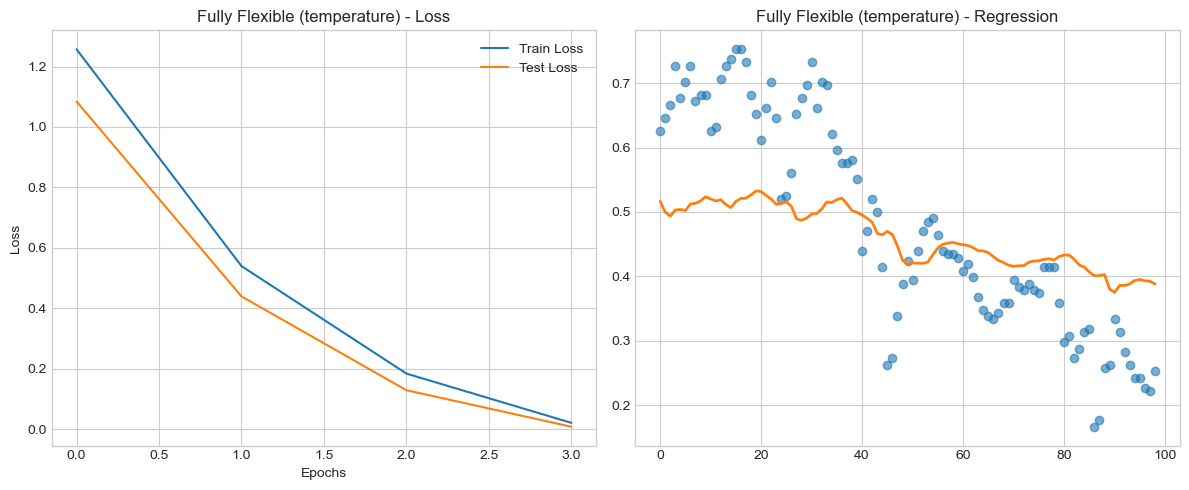

MSE: 0.00292


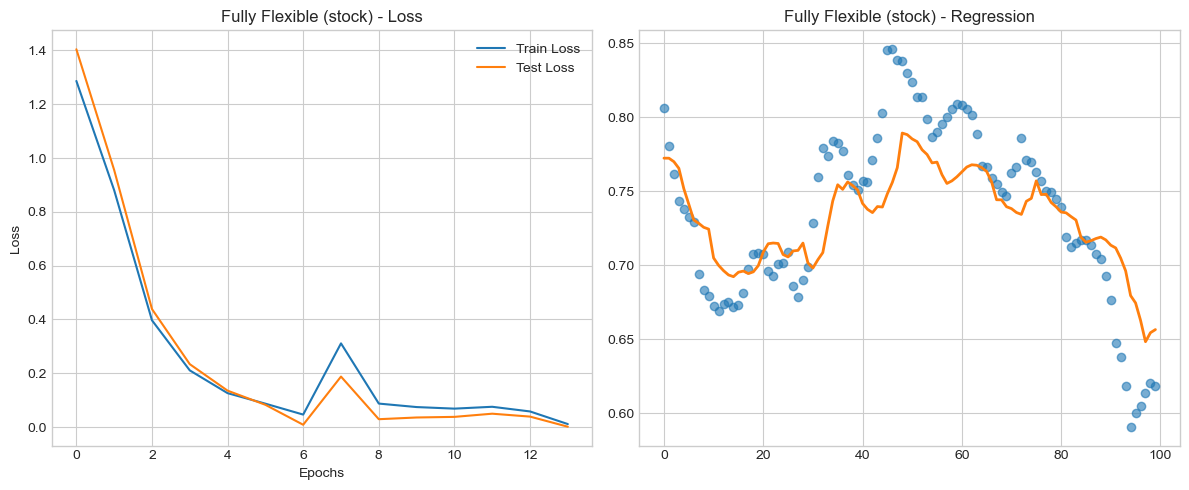

Accuracy: 42.22%


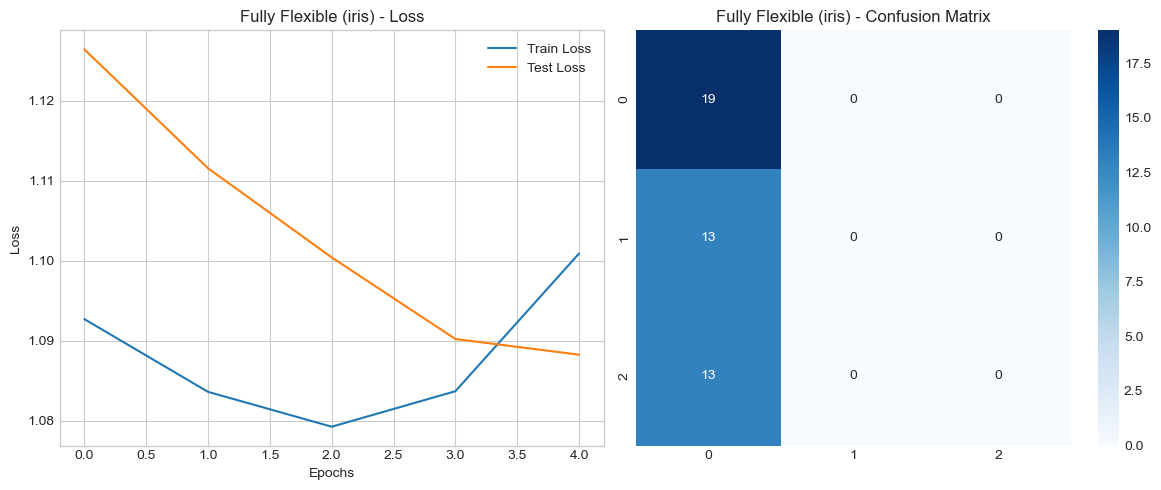

Accuracy: 91.71%


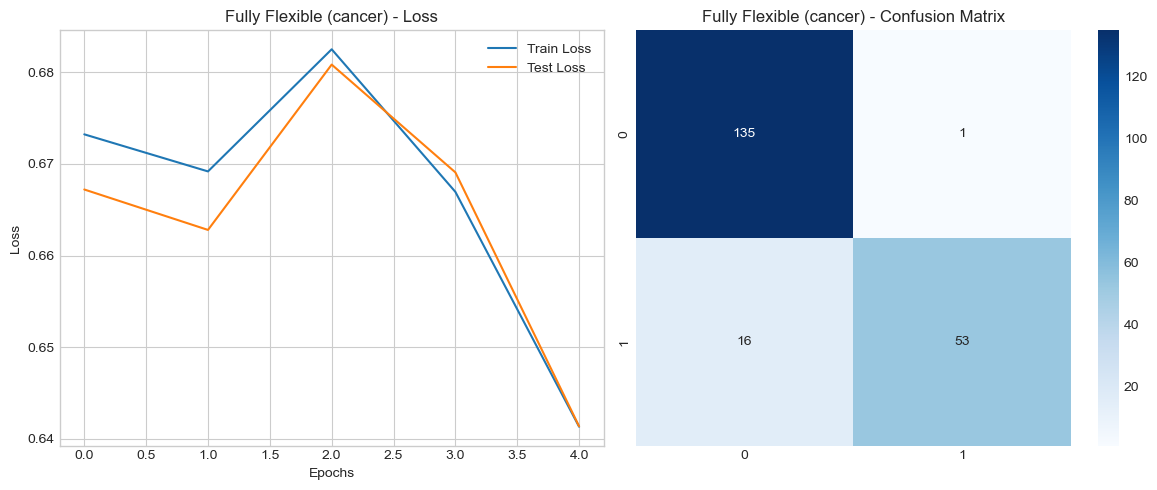

Accuracy: 74.58%


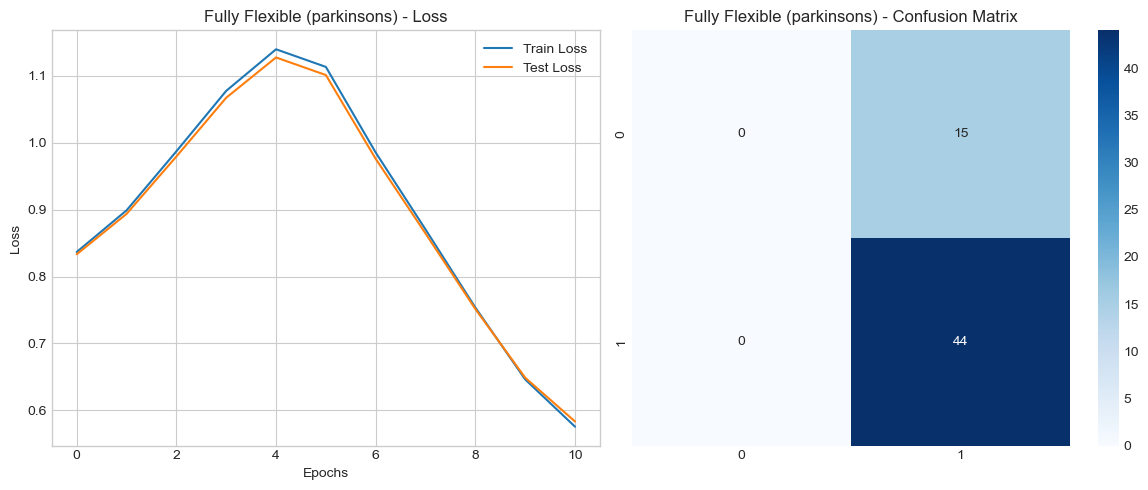

In [9]:
class FullyFlexibleNN(BaseNeuralNetwork):
    def __init__(self, layers, task_type, **kwargs):
        super().__init__(layers, task_type, **kwargs)

        for i in range(1, len(layers) - 1):
            self.params[f'alpha{i}'] = np.ones((1, layers[i])) * 0.5
            self.params[f'beta{i}'] = np.ones((1, layers[i])) * 1.0 
            

def run_fully_flexible(dataset_name, learning_rate=0.1, epochs=20):
    loader = DataLoader()
    data = loader.load_dataset(dataset_name)
    X_train, X_test, y_train, y_test = data[0]
    task_type = data[1]
    
    layers = [X_train.shape[1], 8, 8, 8, y_train.shape[1]]
    model = FullyFlexibleNN(layers, task_type, learning_rate=learning_rate, epochs=epochs)
    model.train(X_train, y_train, X_test, y_test)
    plot_final_results(model, X_test, y_test, f'Fully Flexible ({dataset_name})')

run_fully_flexible('temperature', learning_rate=0.14, epochs=4)
run_fully_flexible('stock', learning_rate=0.2287, epochs=14)
run_fully_flexible('iris', learning_rate=0.025, epochs=5)
run_fully_flexible('cancer', learning_rate=0.075, epochs=5)
run_fully_flexible('parkinsons', learning_rate=0.025, epochs=11)